In [3]:
import sys
import numpy as np
import scipy.stats
from itertools import product
import cvxpy as cp
from collections import Counter, defaultdict
import json
import random
import matplotlib.pyplot as plt

In [4]:
data_dir = '../split_gen_ihart'

In [463]:
# ------------------------------------ Basic Info ------------------------------------
chrom_lengths = {
	'1': 225934550,
	'2': 238204522,
	'3': 194797140,
	'4': 188042934,
	'5': 177695260,
	'6': 167395067,
	'7': 155536559,
	'8': 142964911,
	'9': 120626573,
	'10': 131314747,
	'11': 131169619,
	'12': 130481395,
	'13': 95589878,
	'14': 88289540,
	'15': 81694769,
	'16': 78884753,
	'17': 78129607,
	'18': 74661510,
	'19': 56060841,
	'20': 59505520,
	'21': 35134224,
	'22': 34894566,
	'X': 151100560,
	'Y': 25653566
}


chroms = [str(x) for x in range(1, 23)] #+ ['X', 'Y']

# 0 = 0/0
# 1 = 0/1
# 2 = 1/1
# 3 = -/0 (hemizygous ref)
# 4 = -/1 (hemizygous alt)
# 5 = -/- (double deletion)
gens = [0, 1, 2]


# 0 = 0/0
# 1 = 0/1
# 2 = 1/1
# -1 = ./.
calls = [0, 1, 2, -1]

gen_to_best_call = {0: 0, 1: 1, 2: 2, 3: 0, 4: 2, 5: -1}

mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1),
    (0, 2, 1),
    (0, 3, 0), (0, 3, 3),
    (0, 4, 1), (0, 4, 3),
    (0, 5, 3),
    (1, 0, 0), (1, 0, 1),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2),
    (1, 3, 0), (1, 3, 1), (1, 3, 3), (1, 3, 4),
    (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4),
    (1, 5, 3), (1, 5, 4),
    (2, 0, 1),
    (2, 1, 1), (2, 1, 2),
    (2, 2, 2),
    (2, 3, 1), (2, 3, 4),
    (2, 4, 2), (2, 4, 4),
    (2, 5, 4),
    (3, 0, 0), (3, 0, 3),
    (3, 1, 0), (3, 1, 1), (3, 1, 3), (3, 1, 4),
    (3, 2, 1), (3, 2, 4),
    (3, 3, 0), (3, 3, 3), (3, 3, 5),
    (3, 4, 1), (3, 4, 3), (3, 4, 4), (3, 4, 5),
    (3, 5, 3), (3, 5, 5),
    (4, 0, 1), (4, 0, 3),
    (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4),
    (4, 2, 2), (4, 2, 4),
    (4, 3, 1), (4, 3, 3), (4, 3, 4), (4, 3, 5),
    (4, 4, 2), (4, 4, 4), (4, 4, 5),
    (4, 5, 4), (4, 5, 5),
    (5, 0, 3),
    (5, 1, 3), (5, 1, 4),
    (5, 2, 4),
    (5, 3, 3), (5, 3, 5),
    (5, 4, 4), (5, 4, 5),
    (5, 5, 5)
}

In [464]:
# ------------------------------------ Pull Data ------------------------------------


family_chrom_to_counts = dict()
family_to_inds = dict()
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            famkey, inds = pieces[:2]
            
            if 'ssc' in data_dir:
                # unfortunately, ssc uses . in their sample names
                inds = inds.split('.')
                inds = ['%s.%s' % (inds[i], inds[i+1]) for i in range(0, len(inds), 2)]
            else:
                inds = inds.split('.')

            m = len(inds)

            if m<=7:
                if famkey not in family_to_inds:
                    family_to_inds[famkey] = inds
                else:
                    assert family_to_inds[famkey] == inds
                
                counts = np.zeros((4,)*m, dtype=int)
                for g, c in zip(product([0, 1, 2, 3], repeat=m), pieces[2:]):
                    counts[g] = int(c)
                    
                family_chrom_to_counts[(famkey, chrom)] = counts

print('Families of each size', Counter([len(inds) for fkey, inds in family_to_inds.items()]))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families of each size Counter({4: 436, 5: 357, 6: 56, 3: 18, 7: 13})


In [465]:
# filter families that have all chroms
famkeys = []
for famkey in set([x[0] for x in family_chrom_to_counts.keys()]):
    has_chrom = np.array([(famkey, chrom) in family_chrom_to_counts for chrom in chroms])
    if np.sum(has_chrom) == len(chroms):
        famkeys.append(famkey)
    else:
        print('Missing chromosome counts', famkey, [chrom[i] for i in np.where(~has_chrom)[0]])
famkeys = sorted(famkeys)

print('Families', len(famkeys))


Families 880


# EM

In [466]:
famkey = random.choice(famkeys)
inds = family_to_inds[famkey]
m = len(inds)

print(famkey, m)

AU2617.AU2617202.AU2617201 4


In [467]:
famgens = [x for x in product(gens, repeat=m) if np.all([tuple(x[i] for i in [0, 1, j]) in mendelian_trios for j in range(2, m)])]
famcalls = list(product(calls, repeat=m))
famcall_to_index = dict([(x, i) for i, x in enumerate(famcalls)])
print('famgens', len(famgens), 'famcalls', len(famcalls))


famgens 29 famcalls 256


In [509]:
error_types = [(gen, call) for gen, call in product(gens, calls)]
error_type_to_index = dict([(x, i) for i, x in enumerate(error_types)])

errors = [(ind_index, error_type) for ind_index, error_type in product(range(m), error_types)]
error_to_index = dict([(x, i) for i, x in enumerate(errors)])
print(len(errors), len(error_types))
print(error_types)
print(errors)

48 12
[(0, 0), (0, 1), (0, 2), (0, -1), (1, 0), (1, 1), (1, 2), (1, -1), (2, 0), (2, 1), (2, 2), (2, -1)]
[(0, (0, 0)), (0, (0, 1)), (0, (0, 2)), (0, (0, -1)), (0, (1, 0)), (0, (1, 1)), (0, (1, 2)), (0, (1, -1)), (0, (2, 0)), (0, (2, 1)), (0, (2, 2)), (0, (2, -1)), (1, (0, 0)), (1, (0, 1)), (1, (0, 2)), (1, (0, -1)), (1, (1, 0)), (1, (1, 1)), (1, (1, 2)), (1, (1, -1)), (1, (2, 0)), (1, (2, 1)), (1, (2, 2)), (1, (2, -1)), (2, (0, 0)), (2, (0, 1)), (2, (0, 2)), (2, (0, -1)), (2, (1, 0)), (2, (1, 1)), (2, (1, 2)), (2, (1, -1)), (2, (2, 0)), (2, (2, 1)), (2, (2, 2)), (2, (2, -1)), (3, (0, 0)), (3, (0, 1)), (3, (0, 2)), (3, (0, -1)), (3, (1, 0)), (3, (1, 1)), (3, (1, 2)), (3, (1, -1)), (3, (2, 0)), (3, (2, 1)), (3, (2, 2)), (3, (2, -1))]


In [510]:
y = np.zeros((len(famcalls),))
for chrom in chroms:
    counts = family_chrom_to_counts[(famkey, chrom)]
    for j, famcall in enumerate(famcalls):
        y[j] += counts[famcall]

In [511]:
is_match = np.zeros(y.shape, dtype=bool)
for k, famgen in enumerate(famgens):
    best_famcall = tuple(gen_to_best_call[x] for x in famgen)
    famcall_index = famcall_to_index[best_famcall]
    is_match[famcall_index] = True
print(np.sum(is_match), np.sum(~is_match))

29 227


In [539]:
def update_p(n, y):
    X = np.zeros((len(famcalls), len(errors)))
     
    for k, famgen in enumerate(famgens):
        best_famcall = tuple(gen_to_best_call[x] for x in famgen)
        for ind_index, call in product(range(m), calls):
            if best_famcall[ind_index] != call:
                famcall_index = famcall_to_index[tuple(x if i != ind_index else call for i, x in enumerate(best_famcall))]
                error_index = error_to_index[(ind_index, (famgen[ind_index], call))]
                X[famcall_index, error_index] = n[k]
    
    is_zero_col = np.sum(X[~is_match, :], axis=0)==0
    print('Zero cols:', [errors[i] for i in np.where(is_zero_col)[0]])

    is_zero_row = np.sum(X, axis=1)==0
    print('Removing zero rows:', np.sum(is_zero_row))

    #print([famcalls[i] for i in np.where(~is_match)[0]])
                          
    # cvxpy
    p = cp.Variable(len(errors))
        
    alpha = 1/np.max(y[~is_match & ~is_zero_row])
    print(alpha)
    mu = np.sum(alpha*X[~is_match & ~is_zero_row, :], axis=0)
    objective = cp.Minimize(mu*p - alpha*(y[~is_match & ~is_zero_row])*cp.log(alpha*X[~is_match & ~is_zero_row, :]@p))
    constraints = [p>=0, p<=1]
    for ind_index, gen in product(range(m), gens):
        indices = [i for i, (ind_ind, (g, call)) in enumerate(errors) if ind_index == ind_ind and gen==g]
        constraints.append(cp.sum(p[indices])==1)
        
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='ECOS', max_iters=1000)
    print(prob.status)

    p = np.reshape(np.asarray([v for v in p.value]), (m, len(error_types)))
    
    for gen in gens:
        indices = [i for i, (g, call) in enumerate(error_types) if gen==g]
        assert np.all(np.isclose(np.sum(p[:, indices], axis=1), 1))
        
    # work with zero cols:
    p[np.reshape(is_zero_col, (m, len(error_types)))] = np.nan
    for i in range(len(error_types)):
        if not np.all(np.isnan(p[:, i])):
            p[np.isnan(p[:, i]), i] = 10.0**np.nanmedian(np.log10(p[:, i]))
    
    for gen in gens:
        is_gen = np.array([gen==g for g, call in error_types])
        assert np.all(np.sum(np.isnan(p[:, is_gen]), axis=1) <= 1)
        
        for i in range(m):
            if np.sum(np.isnan(p[i, is_gen])) == 1:
                index = np.where(np.isnan(p[i, :]) & is_gen)[0][0]
                p[i, index] = 1-np.nansum(p[i, is_gen])
                
    assert np.all(p>=0)
    assert np.all(p<=1)
    
    p = np.reshape(p, (len(errors), ))

    return p


Zero cols: [(0, (0, 0)), (0, (0, 1)), (0, (1, 1)), (0, (2, 1)), (0, (2, 2)), (1, (0, 0)), (1, (0, 1)), (1, (1, 1)), (1, (2, 1)), (1, (2, 2)), (2, (0, 0)), (2, (1, 1)), (2, (2, 2)), (3, (0, 0)), (3, (1, 1)), (3, (2, 2))]
Removing zero rows: 121
3.649102320829076e-05
optimal
[9.99365879e-01 2.04680076e-04 4.13492412e-06 4.25306257e-04
 3.07587720e-03 9.95233858e-01 1.20494184e-03 4.85323267e-04
 4.16560654e-11 2.46800397e-04 9.99304386e-01 4.48813398e-04]
[9.99366900e-01 2.04680076e-04 5.51802648e-06 4.22902227e-04
 4.90321364e-03 9.93461990e-01 1.02666716e-03 6.08128867e-04
 3.72760819e-11 2.46800397e-04 9.99336582e-01 4.16618006e-04]
[9.99467049e-01 1.79592329e-04 2.99277406e-06 3.50365616e-04
 6.94467096e-04 9.99077724e-01 4.01804167e-10 2.27808703e-04
 1.74950900e-05 2.38754749e-04 9.99295946e-01 4.47804041e-04]
[9.99403017e-01 2.33272399e-04 2.04219587e-06 3.61668356e-04
 6.86539152e-04 9.99039741e-01 4.35694670e-10 2.73719081e-04
 1.70306795e-05 2.55117170e-04 9.99176414e-01 5.5143

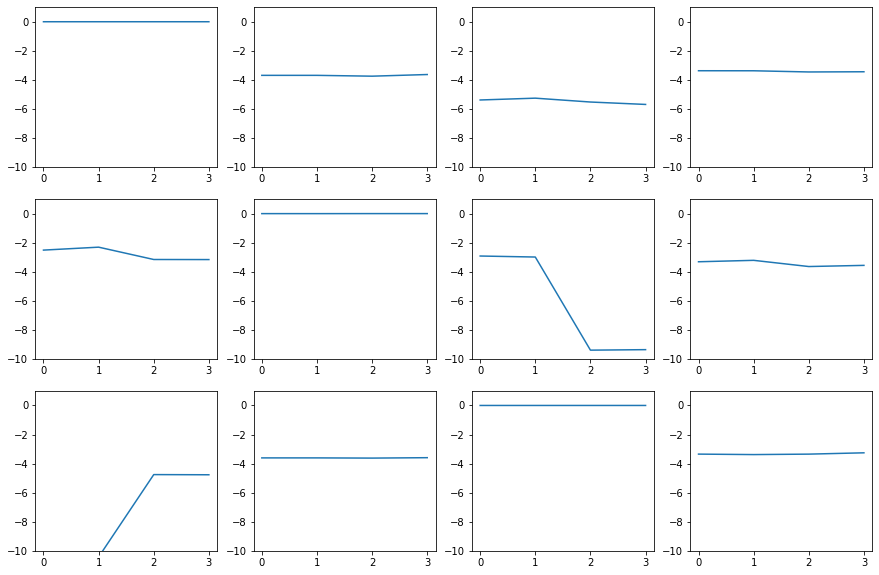

In [540]:
n = np.array([y[famcall_to_index[tuple(gen_to_best_call[x] for x in famgen)]] for famgen in famgens])

p = update_p(n, y)
for i in range(m):
    print(p[(len(error_types)*i):(len(error_types)*(i+1))])
    
plt.figure(figsize=(15, 10))
for j, (gen, call) in enumerate(error_types):
    plt.subplot(3, 4, j+1)
    plt.plot(np.log10([p[error_to_index[(i, (gen, call))]] for i in range(m)]))
    plt.ylim([-10, 1])
plt.show()

In [537]:
def update_n(p, y):
    Q = np.zeros((len(famcalls), len(famgens)))
    
    #for k, famgen in enumerate(famgens):
    #    best_famcall = tuple(gen_to_best_call[x] for x in famgen)
    #    famcall_index = famcall_to_index[best_famcall]
    #    Q[famcall_index, k] = p[-1]
    #    for ind_index, call in product(range(m), calls):
    #        famcall_index = famcall_to_index[tuple(x if i != ind_index else call for i, x in enumerate(best_famcall))]
    #        if best_famcall[ind_index] != call:
    #            error_index = error_to_index[(ind_index, (famgen[ind_index], call))]
    #            Q[famcall_index, k] = p[error_index]
    
    for k, famgen in enumerate(famgens):
        for j, famcall in enumerate(famcalls):
            Q[j, k] = np.product([p[error_to_index[(i, (famgen[i], famcall[i]))]] for i in range(m)])
        
    print(np.max(Q), np.min(Q))
            
    # cvxpy
    n = cp.Variable(len(famgens))
        
    alpha = 1/np.max(y)
    print(alpha)

    mu = np.sum(alpha*Q, axis=0)
    objective = cp.Minimize(mu*n - alpha*y*cp.log(alpha*Q@n))
    constraints = [n>=1]
    
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='ECOS', max_iters=1000)
    print(prob.status)

    n = np.asarray([v for v in n.value])

    return n, Q@n


Zero cols: [0 3]
Removing zero rows: 122
3.649102320829076e-05
optimal
0.9973459393137256 1.6500342264121376e-21
1.559259930953787e-08
optimal_inaccurate
Zero cols: [0 3]
Removing zero rows: 122
3.649102320829076e-05
optimal
0.7717093694358701 2.0639081493882913e-13
1.559259930953787e-08
optimal_inaccurate
Zero cols: [0 3]
Removing zero rows: 122
3.649102320829076e-05
optimal


AssertionError: 

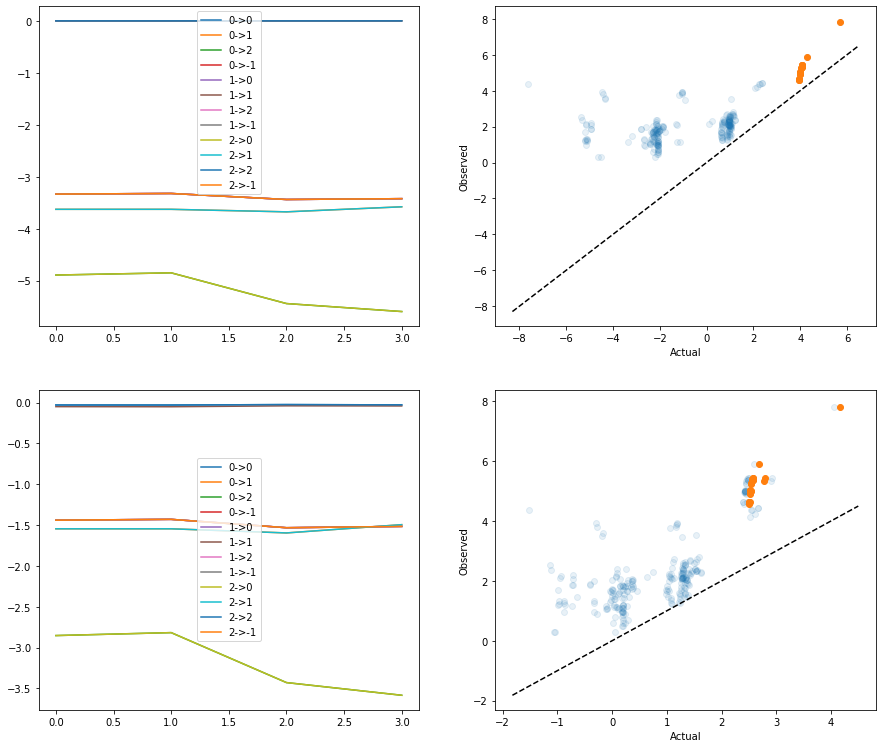

In [538]:
n = np.array([y[famcall_to_index[tuple(gen_to_best_call[x] for x in famgen)]] for famgen in famgens])

plt.figure(figsize=(15, 20))

for it in range(3):
    p = update_p(n, y)

    plt.subplot(3, 2, 2*it + 1)
    for gen, call in product(gens, calls):
        indices = [i for i, (ind_ind, (g, c)) in enumerate(errors) if gen==g and call==c]
        plt.plot(np.log10(p[indices]), label='%s->%s' % (gen, call))
    plt.legend()
    
    n, est = update_n(p, y)

    plt.subplot(3, 2, 2*it + 2)
    plt.scatter(np.log10(est), np.log10(y), alpha=0.1)
    plt.scatter(np.log10(n), 
                np.log10(np.array([y[famcall_to_index[tuple(gen_to_best_call[x] for x in famgen)]] for famgen in famgens])))
    plt.xlabel('Actual')
    plt.ylabel('Observed')
    plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
    
plt.tight_layout()
plt.show()

